In [136]:
import os
import glob

import cv2
from PIL import Image
import numpy as np
import pandas as pd


import pywt
import matplotlib.pyplot as plt

In [137]:
# load image as PIL image
IMAGE_DIR = '../src/data/00001.bmp'
img_array = cv2.imread(glob.glob('../data/input/00000.bmp')[0])
img_array = img_array[...,::-1] # for correct color

img_array.shape

(1080, 1920, 3)

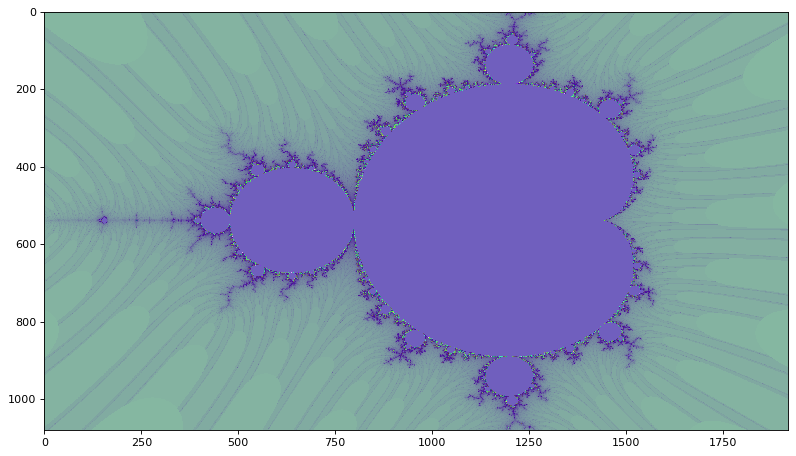

In [138]:
fig = plt.figure(figsize=(12, 12), dpi=80)
plt.imshow(img_array, interpolation='nearest')

fig.savefig('original.png', dpi=300)

In [139]:
# convert to gray scale image 
img_array_gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

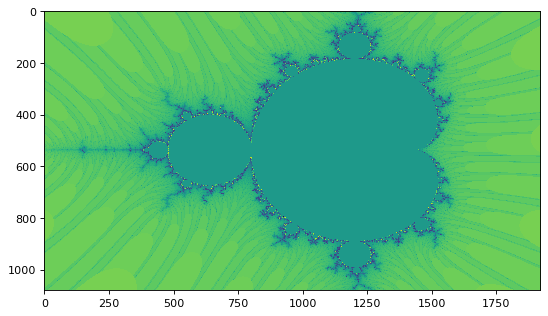

In [140]:
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(img_array_gray, interpolation='nearest')

fig.savefig('original.png', dpi=300)

In [141]:
coeffs = pywt.dwt2(img_array_gray, 'bior1.3')

In [235]:
LL, (LH, HL, HH) = coeffs

In [143]:
HH = abs(HH)

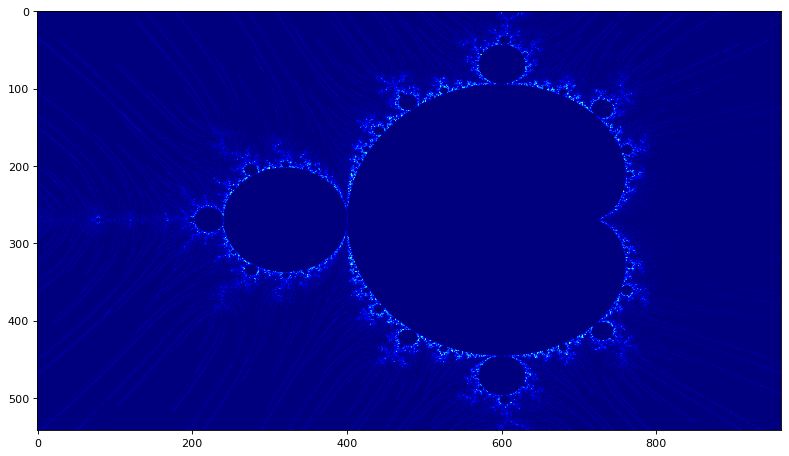

In [172]:
fig = plt.figure(figsize=(12, 12), dpi=80)
plt.imshow(HH, cmap=plt.cm.jet)

fig.savefig('wavelet.png', dpi=300)

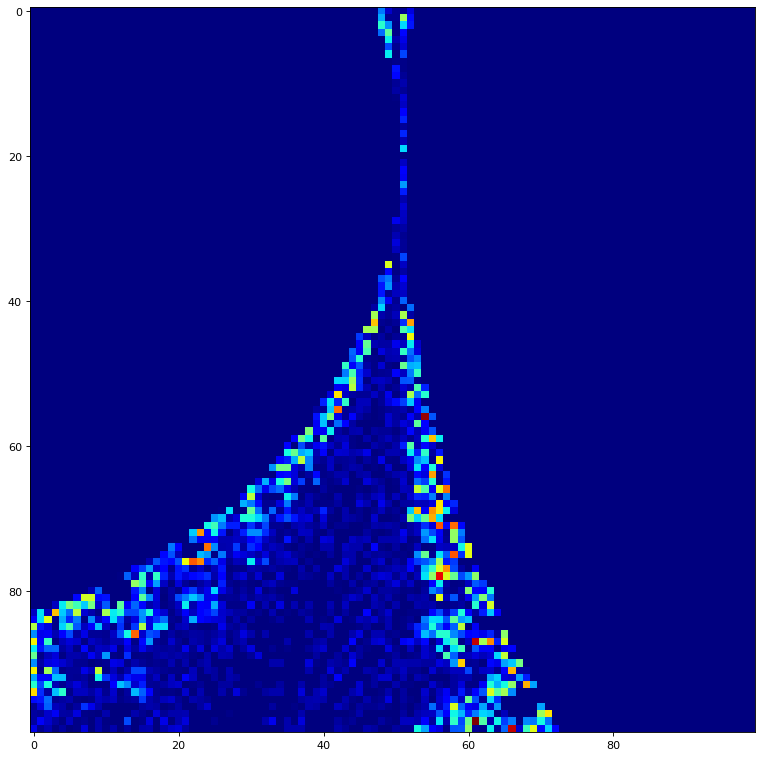

In [173]:
HH_new = HH[250:350, 350:450]

fig = plt.figure(figsize=(12, 12), dpi=80)
plt.imshow(HH_new, cmap=plt.cm.jet)

In [236]:
# create small window 
patchy_size = (6,8) #(240,320) / (6,8) = (40,40)
patchy_size = (4,4) #(240,320) / (6,8) = (40,40)

x_step = 2
y_step = 2

In [227]:
HH = HH_new

In [237]:
idx_x = 0
idx_y = 0

# create a heatmap
#heatmap = np.array(shape=())

patchies = []

while(True):
    # when the bottem end is reached, start from the top with a y-step.  
    if idx_x + patchy_size[0] > HH.shape[0]:
        idx_x = 0
        idx_y += y_step
        # print(f'idx_y + window_size[1]: {idx_y + window_size[1]}, HH_gray_abs.shape[1]: {HH_gray_abs.shape[1]}')
        if (idx_y + patchy_size[1] > HH.shape[1]):                 
            #patchies.append(HH_gray_abs[idx_x: idx_x + window_size[0], idx_y: idx_y + window_size[1]])
            print(f'finished after {len(patchies)} patchies')
            #print(f'{idx_x}:{idx_x + window_size[0]},{idx_y}:{idx_y + window_size[1]}')
            break


        
    #print(f'{len(patchies)}: {idx_x}:{idx_x + window_size[0]},{idx_y}:{idx_y + window_size[1]}')
        
    patchies.append(HH[idx_x: idx_x + patchy_size[0], idx_y: idx_y + patchy_size[1]])
    
    idx_x += x_step

finished after 129600 patchies


In [238]:
patchies[0]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [239]:
# create heatmap via mean pooling
heatmap = np.ones(len(patchies))
for i in range(heatmap.shape[0]):
    heatmap[i] = patchies[i].mean() # take abs?

In [240]:
heatmap

array([0., 0., 0., ..., 0., 0., 0.])

In [241]:
np.max(heatmap)

23.78125

In [242]:
# reshape heatmap from 1D to 2D and transpose it
overlap_x = patchy_size[0] - x_step
overlap_y = patchy_size[1] - y_step

size_x = int((HH.shape[0] - 2 * patchy_size[0] + overlap_x) / (patchy_size[0] - overlap_x) + 2)
size_y = int((HH.shape[1] - 2 * patchy_size[1] + overlap_y) / (patchy_size[1] - overlap_y) + 2)


print(f'size_x: {size_x}')
print(f'size_y: {size_y}')

heatmap = heatmap.reshape(size_x, size_y).T

size_x: 270
size_y: 480


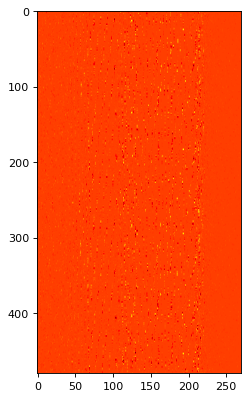

In [243]:
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(heatmap, cmap=plt.cm.hot)

fig.savefig('patchies.png', dpi=300)

In [244]:
img_array.shape

(1080, 1920, 3)

In [154]:
width = img_array.shape[1]
height = img_array.shape[0]

heatmap_resized = np.abs(cv2.resize(heatmap, (width, height), interpolation=cv2.INTER_CUBIC))
heatmap_resized = heatmap_resized.astype(np.uint8)
heatmap_resized.shape, np.max(heatmap_resized)

((1080, 1920), 21)

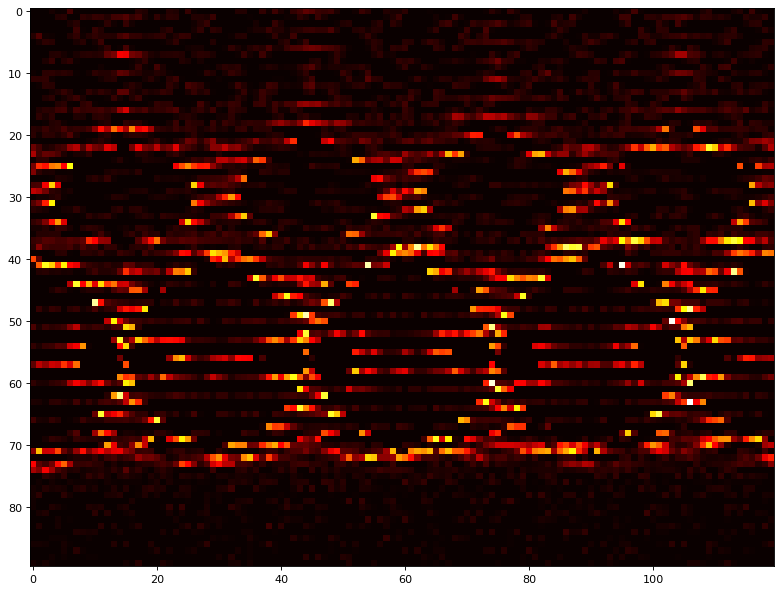

In [155]:
fig = plt.figure(figsize=(12, 12), dpi=80)
plt.imshow(heatmap, cmap=plt.cm.hot)

fig.savefig('patchies.png', dpi=300)

In [156]:
cmap = plt.get_cmap('jet')


heatmap_rescaled = np.interp(heatmap_resized, (heatmap_resized.min(), heatmap_resized.max()), (0, 255)).astype(np.uint8)

rgba_img = cmap(heatmap_rescaled)[:,:,:3]
rgba_img = rgba_img * 255.
rgba_img = rgba_img.astype(np.uint8)
rgba_img.dtype, rgba_img.shape

(dtype('uint8'), (1080, 1920, 3))

In [157]:
np.unravel_index(heatmap_resized.argmax(), heatmap_resized.shape)

(497, 1528)

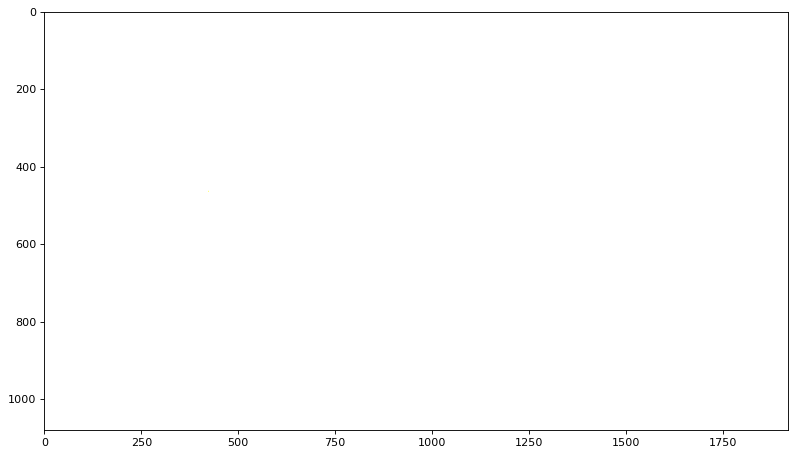

In [158]:
mask = np.ones_like(heatmap_resized)
mask[464, 424] = 0

fig = plt.figure(figsize=(12, 12), dpi=80)
plt.imshow(mask, cmap=plt.cm.hot)

In [159]:
dim0, dim1 = np.unravel_index(heatmap_resized.argmax(), heatmap_resized.shape)

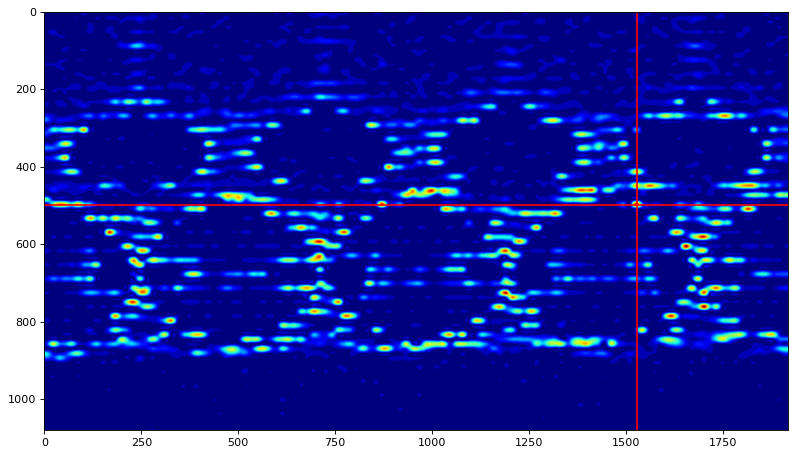

In [160]:
fig = plt.figure(figsize=(12, 12), dpi=80)
plt.imshow(rgba_img)
plt.axhline(y=dim0, color='r', linestyle='-')
plt.axvline(x=dim1, color='r', linestyle='-')


In [161]:
# compute center of highest mean
np.unravel_index(rgba_img.argmax(), rgba_img.shape)

(1, 716, 2)

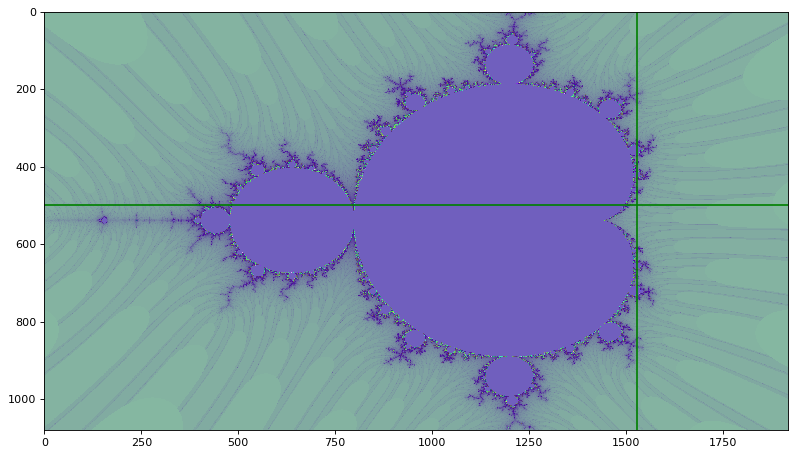

In [162]:
fig = plt.figure(figsize=(12, 12), dpi=80)
plt.imshow(img_array, interpolation='nearest')
plt.axhline(y=dim0, color='green', linestyle='-')
plt.axvline(x=dim1, color='g', linestyle='-')

In [163]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

In [164]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 6)
        self.conv2 = nn.Conv2d(32, 32, 6)
        self.conv3 = nn.Conv2d(32, 64, 4, 2)
        self.conv4 = nn.Conv2d(64, 128, 4, 2)
        self.dropout1 = nn.Dropout2d(0.3)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(11264, 6048) # nn.Linear(6272, 2048)
        self.fc2 = nn.Linear(6048, 2096)
        self.fc3 = nn.Linear(2096, 1024)
        self.fc3 = nn.Linear(1024, 128)
        self.fc4 = nn.Linear(128, 2)
        

    def forward(self, x):
        
        x = self.conv1(x)
        #print(x.size())
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 4)
        #x = self.dropout1(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 4)
        #x = self.dropout1(x)
        
        #return x
        

        x = torch.flatten(x, 1)
        
        print(f' SHAPE: {x.shape}')
        #return x
        
        x = self.fc1(x)
        
        return 0
        x = F.relu(x)
        #x = self.dropout2(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        #x = self.dropout2(x)
        
        x = self.fc3(x)
        x = F.relu(x)
        #x = self.dropout2(x)  
        
        x = self.fc4(x)
        
        #print(x.size())
        output = F.log_softmax(x,dim=-1)
        return output

In [165]:
model = Net()

ValueError: At least one stride in the given numpy array is negative, and tensors with negative strides are not currently supported. (You can probably work around this by making a copy of your array  with array.copy().) 

<Figure size 960x960 with 0 Axes>

In [167]:
img_pil = Image.open(glob.glob(f'../data/input/00001.bmp')[0])

trans = transforms.ToTensor()
trans1 = transforms.ToPILImage()

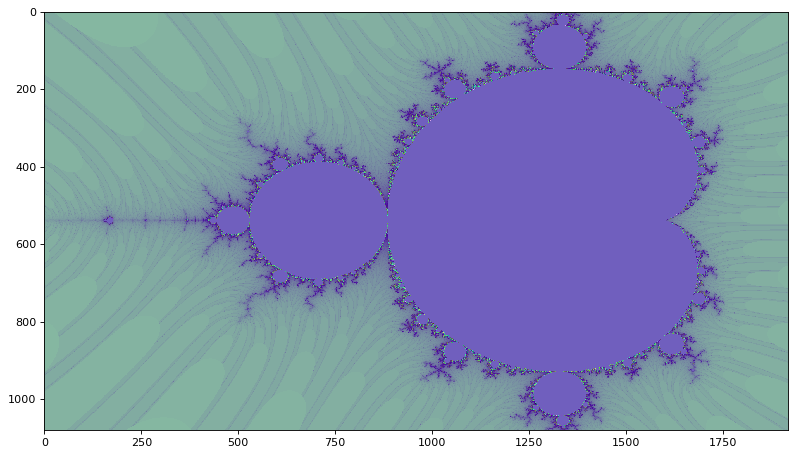

In [168]:
fig = plt.figure(figsize=(12, 12), dpi=80)
plt.imshow(trans1(trans(img_pil)), interpolation='nearest')

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [32, 3, 6, 6], but got 3-dimensional input of size [3, 600, 800] instead

In [130]:
model(trans(img_pil).unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x11264 and 6272x2048)

In [133]:
tot = 32

patchie_size = 8
step = 1
overlap = patchie_size - step

num_patchies = (tot - 2*patchie_size + overlap) / (patchie_size - overlap) + 2
num_patchies

25.0